<a href="https://colab.research.google.com/github/prit-tech/Sarcasm-Detection/blob/master/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Description:**
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected
using hashtag based supervision but such datasets are noisy in terms of labels and
language. Furthermore, many tweets are replies to other tweets and detecting
sarcasm in these requires the availability of contextual tweets.
In this hands-on project, the goal is to build a model to detect whether a sentence
is sarcastic or not, using Bidirectional LSTMs.

**Data Description:**
News Headlines dataset for Sarcasm Detection. The dataset is collected from two
news websites, theonion.com and huffingtonpost.com. This new dataset has the
following advantages over the existing Twitter datasets:
Since news headlines are written by professionals in a formal manner, there are
no spelling mistakes and informal usage. This reduces the sparsity and also
increases the chance of finding pre-trained embedding.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we
get high-quality labels with much less noise as compared to Twitter datasets.
Unlike tweets that reply to other tweets, the news headlines obtained are self-
contained. This would help us in teasing apart the real sarcastic elements
Content
Each record consists of three attributes:
- is_sarcastic: 1 if the record is sarcastic otherwise 0
- headline: the headline of the news article


## Get Required Files from Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir('/content/drive/My Drive/Colab/Deep Learning/Natural Language Processing/Project-Twiter/Data/')
path = '.'

In [4]:
pwd

'/content/drive/My Drive/Colab/Deep Learning/Natural Language Processing/Project-Twiter/Data'

In [0]:
#Set your project path 
project_path =  '/content/drive/My Drive/Colab/Deep Learning/Natural Language Processing/Project-Twiter/Data/'

#**## Reading and Exploring Data**

In [0]:
import numpy as np 
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow import keras
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import Activation, Dense
from keras.layers import Dropout, Flatten
from keras import regularizers
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K
from bs4 import BeautifulSoup
import re, string
from nltk.corpus import stopwords

## Read Data "Sarcasm_Headlines_Dataset.json". Explore the data and get  some insights about the data.

In [83]:
df = pd.read_json(project_path+'/Sarcasm_Headlines_Dataset.json', lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


#### Shape of the Data:-

In [8]:
raws_count, columns_count = df.shape
print('Total Number of Rows    :', raws_count)
print('Total Number of Columns :', columns_count)

Total Number of Rows    : 26709
Total Number of Columns : 3


<b>Comment :</b> Shape of the dataframe is (26709, 3). There are 26709 rows and 3 columns in the dataset.

#### Datatype of each attribute:-

In [9]:
df.dtypes

article_link    object
headline        object
is_sarcastic     int64
dtype: object

#### Checking the presence of missing values :-

In [10]:
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

<b>Comment:</b> As we see above there is no nan value in our data set which is a good sign.

#### Our target column is is_sarcastic :- 

In [11]:
df['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [12]:
subscriber_counts = pd.DataFrame(df["is_sarcastic"].value_counts()).reset_index()
subscriber_counts.columns =["Labels","is_sarcastic"]
subscriber_counts

,Labels,is_sarcastic
0,0,14985
1,1,11724


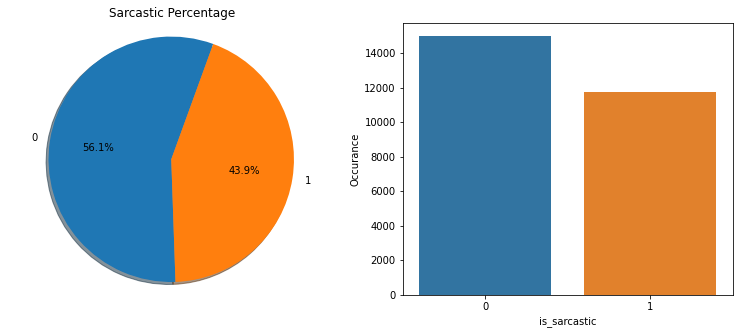

In [13]:
fig1, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
explode = (0, 0)
ax1.pie(subscriber_counts['is_sarcastic'], explode=explode, labels=subscriber_counts["Labels"], autopct="%1.1f%%", shadow=True, startangle=70)
ax1.axis('equal')
ax1.set_title("Sarcastic Percentage")

sns.countplot(df['is_sarcastic'], data=df, ax = ax2)
ax2.set_xlabel('is_sarcastic')
ax2.set_ylabel('Occurance')

plt.show()

**Important** : From the above we can see the data distribution ('sarcastic%': 43.9%, 'not sarcastic%':56.1%). By looking the percentage we can say that data is almost balanced.

### Wordcloud for text that is not sarcastic (LABEL - 0) :-

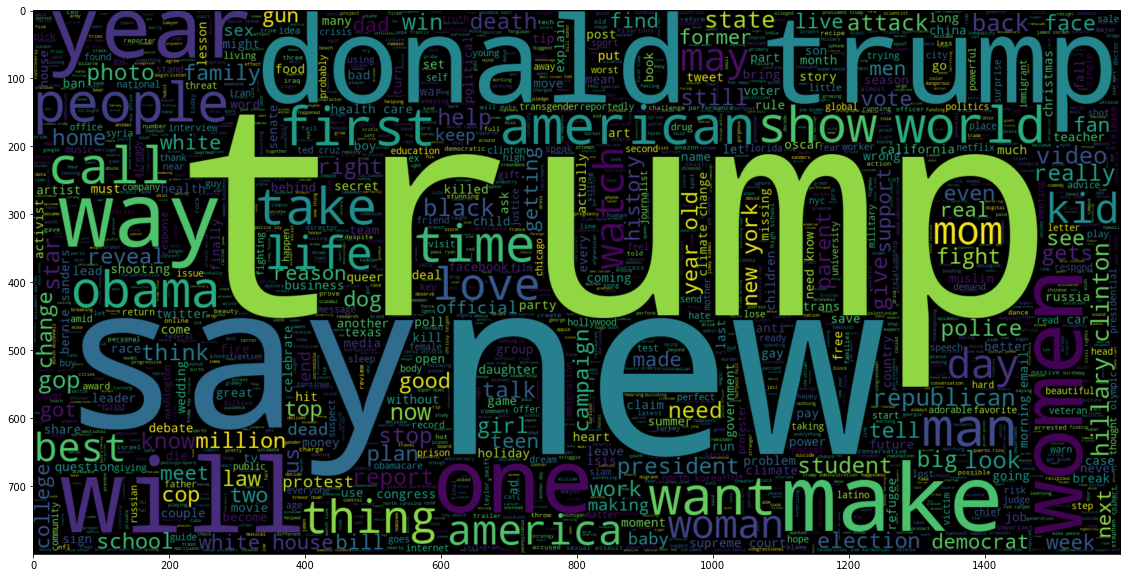

In [50]:
plt.figure(figsize = (20,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

**Insight** : Above I have used the wordcloud to show the most common words which are under Non-Sarcastic sentance.

### Wordcloud for text that is sarcastic (LABEL - 1) :-

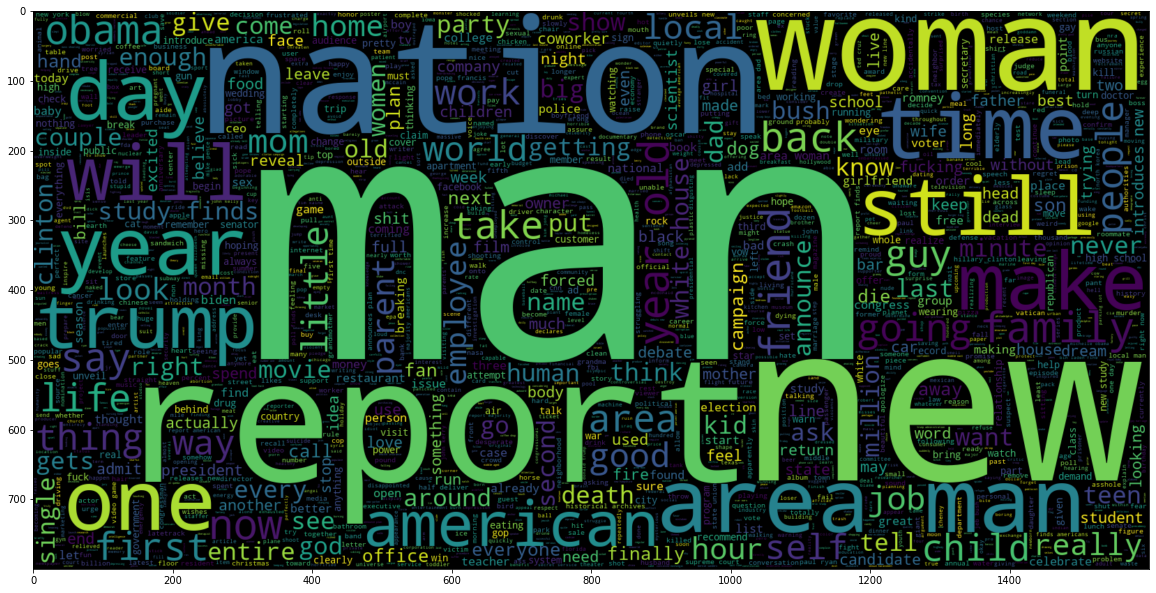

In [0]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

**Insight** : Above I have used the wordcloud to show the most common words which are under Sarcastic sentance.

#### Basic Data Cleaning:-

In [0]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [0]:
#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
   # text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)


## Drop `article_link` from dataset.

In [0]:
df = df.drop('article_link', axis=1)

In [85]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues secret 'black ...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,'roseanne' revival catches thorny political mo...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting fear son's web series closest thi...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner wants wife listen, come alternative de...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday magic...,0


**Comment**: Here I have deleted the article_link as it is not a good predictor and also mentioned in steps.

## Get the Length of each line and find the maximum length.

In [87]:
all_line_len = list(map(lambda x : len(x.split()),df['headline']))
maxlen = max(all_line_len)
count_df = pd.DataFrame({'Headline': df["headline"], 'Length': all_line_len })
count_df.head()

,Headline,Length
0,former versace store clerk sues secret 'black ...,10
1,'roseanne' revival catches thorny political mo...,8
2,mom starting fear son's web series closest thi...,9
3,"boehner wants wife listen, come alternative de...",8
4,j.k. rowling wishes snape happy birthday magic...,8


In [88]:
print('Maximum length of Line : ', maxlen)

Maximum length of Line :  27


#**## Modelling**

## Import required modules required for modelling.

In [0]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

# Set Different Parameters for the model

In [0]:
max_features = 10000
maxlen = maxlen
embedding_size = 200

## Apply Keras Tokenizer of headline column of your data.

In [0]:
tokenizer = Tokenizer(num_words=max_features)

In [0]:
tokenizer.fit_on_texts(df['headline'])

# Define X and y for your model.

In [0]:
X = tokenizer.texts_to_sequences(df['headline'])

In [93]:
len(X )

26709

In [94]:
X = tokenizer.texts_to_sequences(df['headline'])
X = pad_sequences(X, maxlen = maxlen, padding='post')
y = np.asarray(df['is_sarcastic'])

print("Number of Samples:", len(X))
print("------------------------------------------")
print(X[0])
print("------------------------------------------")
print("Number of Labels: ", len(y))
print("\n------------------------------------------")
print(y[0])

Number of Samples: 26709
------------------------------------------
[ 215  571 3236 2191  286 2471 2472 8351    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]
------------------------------------------
Number of Labels:  26709

------------------------------------------
0


In [95]:
X.shape

(26709, 27)

## Get the Vocabulary size

In [0]:
vocab_size = len(tokenizer.word_index) +1

In [97]:
print('Vocabulary Size : ', vocab_size)

Vocabulary Size :  29590


#**## Word Embedding**

## Get Glove Word Embeddings

In [0]:

glove_file = "./glove.6B.zip"

In [0]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

# Get the Word Embeddings using Embedding file as given below.

In [0]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    #print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd



# Create a weight matrix for words in training docs

In [0]:
num_words = vocab_size

In [103]:
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(len(embeddings.values()))
print(len(embedding_matrix))
print(embedding_matrix.shape)

400000
29590
(29590, 200)


## Create and Compile your Model
Hint - Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.


In [0]:
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D

In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(vocab_size, embedding_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(embedding_size, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(300, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

In [115]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 27)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 27, 200)           5918000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 27, 400)           641600    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301 

# Fit your model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy


In [116]:
X.shape

(26709, 27)

In [117]:
y.shape

(26709,)

### Train Test split :-

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2 , random_state = 7) 

In [144]:
print('x_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('x_test  shape: ', X_test.shape)
print('y_test  shape: ', y_test.shape)

x_train shape:  (21367, 27)
y_train shape:  (21367,)
x_test  shape:  (5342, 27)
y_test  shape:  (5342,)


#### Compiling the model and setting the calback :-

In [0]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience=5)]
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training the Model and Reporting the Accuracy of the model:-

In [0]:
batch_size = 100
epochs = 5


In [147]:
%%time
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 22s 1ms/step - loss: 0.1683 - accuracy: 0.9420 - val_loss: 0.1410 - val_accuracy: 0.9502
Epoch 2/5
21367/21367 [==============================] - 22s 1ms/step - loss: 0.1045 - accuracy: 0.9645 - val_loss: 0.1692 - val_accuracy: 0.9364
Epoch 3/5
21367/21367 [==============================] - 22s 1ms/step - loss: 0.0626 - accuracy: 0.9781 - val_loss: 0.2024 - val_accuracy: 0.9272
Epoch 4/5
21367/21367 [==============================] - 21s 1ms/step - loss: 0.0370 - accuracy: 0.9869 - val_loss: 0.2607 - val_accuracy: 0.9219
Epoch 5/5
21367/21367 [==============================] - 22s 1ms/step - loss: 0.0231 - accuracy: 0.9923 - val_loss: 0.2922 - val_accuracy: 0.9212
CPU times: user 2min 38s, sys: 21.9 s, total: 3min
Wall time: 1min 50s


In [148]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

5342/5342 [==============================] - 2s 310us/step


In [149]:
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Test loss: 0.29217948655286496
Test accuracy: 0.9211905598640442


#### Anayisys after training of glove Embeddings model :-

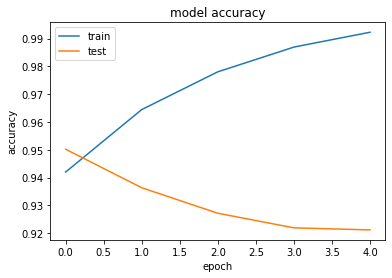

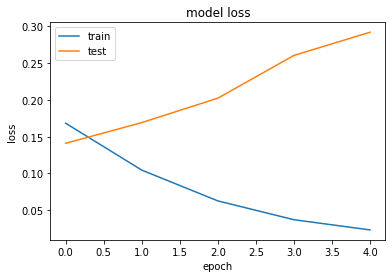

In [150]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Making predicitions :-

In [151]:
%%time
mode_predict=model.predict(X_test)

CPU times: user 1.74 s, sys: 61.7 ms, total: 1.8 s
Wall time: 1.67 s


In [152]:
y_predict=mode_predict.ravel()
y_predict=(y_predict>0.5)
y_predict[0:10]

array([ True,  True, False,  True,  True,  True, False, False,  True,
        True])

In [0]:
predicted = model.predict(X_test)
predicted_y = predicted.round().ravel().astype('int32')

In [154]:
predicted_df = pd.DataFrame( { "Y Actual":y_test, "Y Predicted": predicted_y } )
predicted_df.head()

,Y Actual,Y Predicted
0,1,1
1,1,1
2,0,0
3,1,1
4,1,1


#### Comment: Above I have displayed the actual and predicted label

### Classification report for performance metrics:-

In [155]:
print(classification_report(y_test, y_predict, target_names = ['Not Sarcastic','Sarcastic']))

               precision    recall  f1-score   support

Not Sarcastic       0.93      0.93      0.93      3041
    Sarcastic       0.91      0.90      0.91      2301

     accuracy                           0.92      5342
    macro avg       0.92      0.92      0.92      5342
 weighted avg       0.92      0.92      0.92      5342



In [0]:
confusionMatrix = confusion_matrix(y_test,y_predict)

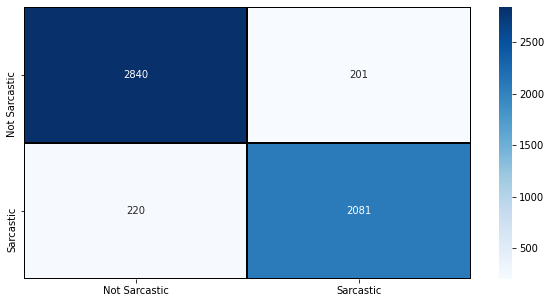

In [157]:
confusionMatrix = pd.DataFrame(confusionMatrix , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,5))
sns.heatmap(confusionMatrix,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])

### Predicting the headline's sarcasm for test samples:-

In [0]:
INDEX_FROM=3 
word_to_id = tokenizer.word_index
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3

id_to_word = {value:key for key,value in word_to_id.items()}

### Here I am taking two sample headlines from test dataset:-

##### Here I am taking two test samples:-

In [0]:
test_sample_1 = 202
test_sample_2 = 113

In [0]:
headline_1 = X_test[test_sample_1]
headline_2 = X_test[test_sample_2]

In [162]:
print('Actual label of first sample headline  : {}'.format(y_test[test_sample_1]))
print('\n==================================\n')

print(' '.join(id_to_word[id] for id in headline_1 ))

Actual label of first sample headline  : 1


way moon healthy hillary ed texas milosevic <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [163]:
print('Actual label of second sample headline  : {}'.format(y_test[test_sample_2]))
print('\n==================================')
print(' '.join(id_to_word[id] for id in headline_2 ))

Actual label of second sample headline  : 1

<UNUSED> hear actually going years coming visa 13 audience streaming <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [164]:
# Texts 
texts = (headline_1, headline_2)
padded_texts = pad_sequences(texts, maxlen=maxlen, value = 0.0)

# Generating predictions
predictions = model.predict(padded_texts)
print(predictions[0])
print(predictions[1])

[1.]
[1.]


**Above we can see the probability of both the sample reviews which I have taken from test dataset.**

  **My consideration:**
    As I have used sigmoid activation funtion so if predicted probability of a headline is greater than 0.5 which will be considered as 'sarcastic' or else headline's s will be classified as a 'not sarcastic'.

### Here defining a function to classify the headline's sarcasm:

In [0]:
def predict_sarcasm(predict):
    predicted_probability = int(np.round(predict))
    if predicted_probability == 0:
      return 'Not Sarcastic'
    else :
      return 'Sarcastic'

In [166]:
 print("Headline's sarcasm for first sample is  : " + predict_sarcasm(predictions[0]))

Headline's sarcasm for first sample is  : Sarcastic


In [167]:
print("Headline's sarcasm for second sample is : " + predict_sarcasm(predictions[1]))

Headline's sarcasm for second sample is : Sarcastic


**Summary::**

From the above test samples :

For the first headline, the prediction is 0.0016063 which is close to 0. This makes sense that the text clearly indicates that the headline is **Not-Sarcastic** in nature. 
For the second headline, the prediction is 0.9904986 which is close to 1. This makes sense that the text indicates that the headline is **Sarcastic** in nature.